In [61]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PyMPDATA-examples')

In [62]:
import numpy as np
import numba
import pint
numba.set_num_threads(1)
si=pint.UnitRegistry()
from matplotlib import pyplot
from open_atmos_jupyter_utils import show_plot, show_anim
from PyMPDATA import ScalarField, Solver, Stepper, VectorField, Options, boundary_conditions

In [63]:
class ShallowWaterEquationsIntegrator:
    def __init__(self, *, h_initial: np.ndarray, bathymetry: np.ndarray=None, options: Options = None):
        """ initializes the solvers for a given initial condition of `h` assuming zero momenta at t=0 """
        options = options or Options(nonoscillatory=True, infinite_gauge=True)
        self.bathymetry = bathymetry
        X, Y, grid = 0, 1, h_initial.shape
        stepper = Stepper(options=options, grid=grid)
        kwargs = {
            'boundary_conditions': [boundary_conditions.Constant(value=0)] * len(grid),
            'halo': options.n_halo,
        }
        advectees = {
            "h": ScalarField(h_initial, **kwargs),
            "uh": ScalarField(np.zeros(grid), **kwargs),
            "vh": ScalarField(np.zeros(grid), **kwargs),
        }
        self.advector = VectorField((
                np.zeros((grid[X] + 1, grid[Y])),
                np.zeros((grid[X], grid[Y] + 1))
            ), **kwargs
        )
        self.solvers = { k: Solver(stepper, v, self.advector) for k, v in advectees.items() }

    def __getitem__(self, key):
        """ returns `key` advectee field of the current solver state """
        return self.solvers[key].advectee.get()

    def _apply_half_rhs(self, *, key, axis, g_times_dt_over_dxy):
        """ applies half of the source term in the given direction """
        self[key][:] -= .5 * g_times_dt_over_dxy * self['h'] * np.gradient(self['h']-self.bathymetry, axis=axis)

    def _update_courant_numbers(self, *, axis, key, mask, dt_over_dxy):
        """ computes the Courant number component from fluid column height and momenta fields """
        velocity = np.where(mask, np.nan, 0)
        momentum = self[key]
        np.divide(momentum, self['h'], where=mask, out=velocity)

        # using slices to ensure views (over copies)
        all = slice(None, None)
        all_but_last = slice(None, -1)
        all_but_first_and_last = slice(1, -1)

        velocity_at_cell_boundaries = velocity[(
            (all_but_last, all),
            (all, all_but_last),
        )[axis]] + np.diff(velocity, axis=axis) / 2
        courant_number = self.advector.get_component(axis)[(
            (all_but_first_and_last, all),
            (all, all_but_first_and_last)
        )[axis]]
        courant_number[:] = velocity_at_cell_boundaries * dt_over_dxy[axis]
        assert np.amax(np.abs(courant_number)) <= 1

    def __call__(self, *, nt: int, g: float, dt_over_dxy: tuple, outfreq: int, eps: float=1e-7):
        """ integrates `nt` timesteps and returns a dictionary of solver states recorded every `outfreq` step[s] """
        output = {k: [] for k in self.solvers.keys()}
        for it in range(nt + 1):
            if it != 0:
                mask = self['h'] > eps
                for axis, key in enumerate(("uh", "vh")):
                    self._update_courant_numbers(axis=axis, key=key, mask=mask, dt_over_dxy=dt_over_dxy)
                self.solvers["h"].advance(n_steps=1)
                for axis, key in enumerate(("uh", "vh")):
                    self._apply_half_rhs(key=key, axis=axis, g_times_dt_over_dxy=g * dt_over_dxy[axis])
                    self.solvers[key].advance(n_steps=1)
                    self._apply_half_rhs(key=key, axis=axis, g_times_dt_over_dxy=g * dt_over_dxy[axis])
            if it % outfreq == 0:
                for key in self.solvers.keys():
                    output[key].append(self[key].copy())
        return output

# Jak okrągłe anomalie w dnie wpływają na pole prędkości i kształt rozchodzenia się fali?
#### Symulacja bazuje na równaniach płytkiej wody (Shallow Water Equations), które modelują przepływy wody o małej głębokości (gdzie pionowe przyspieszenie jest zaniedbywalne). Układ jest dwuwymiarowy (x,y).
#### Projekt miał na celu sprawdzenie jak zachowuje się powierzchnia wody i rozkład wektorów prędkości po wprowadzeniu symetrycznych walcowatych przeszkód. Zbadano te własności dla różnych rozmiarów wspomnianych anomali. Dla wszytskich przypadków wymiary dna były takie same i wyniosły $L_x$ = 200m i $L_y$ = 160m.




In [64]:
Lx = 200*si.meter
Ly = 160*si.meter
g = 9.81*si.meter/si.second**2

## Najpierw wszytsko wykonano dla:
## - rozmiar siatki: grid = (50,40)
## - rozdzielczość przestrzenna $\Delta x$ = $L_x$/50=40m; $\Delta y$ = $L_y$/40=40m
## - rozdzielczość czasowa $\Delta t$ = 0.25s
## - liczba kroków czasowych: nt=90


In [65]:
grid = (50, 40)
dx = Lx / grid[0]
dy = Ly / grid[1]
dt = .25*si.second
dt_over_dxy = ((dt/dx).m, (dt/dy).m)

x = np.linspace(-Lx.m/2, Lx.m/2, grid[0])
y = np.linspace(-Ly.m/2, Ly.m/2, grid[1])
X, Y = np.meshgrid(x, y, indexing="ij")

#### Początkowe Zaburzenie (ζ): Jest to impuls fali (paczką falową) o kształcie prostokąta, zlokalizowany w centrum siatki. Amplituda zaburzenia wynosi 0.25m

In [66]:
zeta = np.zeros(grid, dtype=float)
zeta[
    grid[0] // 2 - grid[0] // 20:
    grid[0] // 2 + grid[0] // 20,
    grid[1] // 2 - grid[1] // 20:
    grid[1] // 2 + grid[1] // 20
] += .25
zeta=zeta*si.meter

### Na początku rozważane przeszkody miały promień 40m.  Spodziewano się spiętrzenie fali na przeszkodach i swobodnym przepływnie w kieunkach bez przeszkód.
#### Głębokość Podstawowa: 2.0 m (jednolita głębokość w całym dnie, z wyjątkiem wysp). Zaimplementowano dwie kołowe wyspy, których wysokość wyniosła 0.8m
#### - Wyspa 1: Środek w x1​=60 m, y1​=0 m.

#### - Wyspa 2: Środek w x2​=−60 m, y2​=0 m.

In [67]:
bathymetry = np.full(grid, 2.0)

radius = 40*si.meter
height = .8*si.meter
# pierwsza wyspa
x1 = 60.0
y1 = 0.0
mask1 = (X - x1)**2 + (Y - y1)**2 < radius.m**2
bathymetry[mask1] = height.m
# druga wyspa
x2 = -60.0
y2 = 0.0
mask2 = (X - x2)**2 + (Y - y2)**2 < radius.m**2
bathymetry[mask2] = height.m
bathymetry = bathymetry*si.meter

In [68]:
h_initial = bathymetry + zeta


output = ShallowWaterEquationsIntegrator(
    h_initial=h_initial.m, bathymetry=bathymetry.m,
)(
    nt=90, g=g.m, dt_over_dxy=dt_over_dxy, outfreq=(outfreq:=3)
)

#### Wykonano wizualizację tak zadanego dna z impulsem początkowym

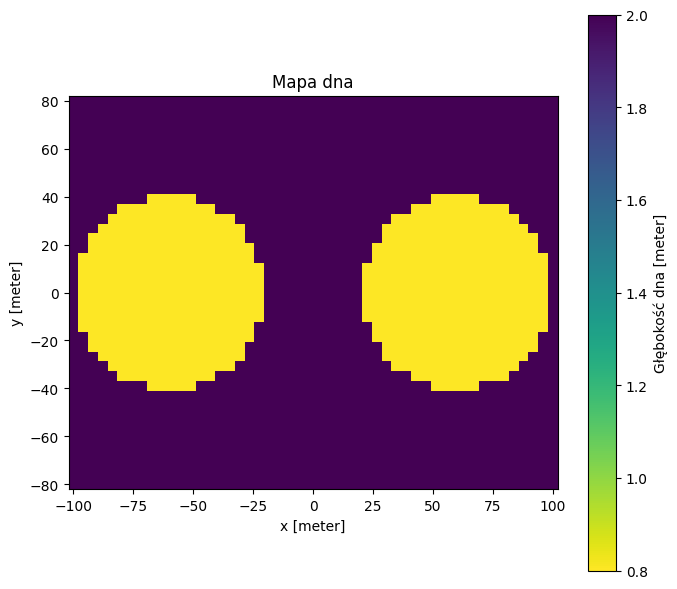

In [69]:
x_with_units = np.linspace(-Lx.m/2, Lx.m/2, X.shape[0]) * si.meter
y_with_units = np.linspace(-Ly.m/2, Ly.m/2, Y.shape[1]) * si.meter
X_values, Y_values = np.meshgrid(x_with_units, y_with_units, indexing="ij")


bathymetry_values = bathymetry.m

bathymetry_units = str(bathymetry.units)
x_units = str(X_values.units)
y_units = str(Y_values.units)

pyplot.figure(figsize=(7, 6))
pc = pyplot.pcolormesh(X_values.m, Y_values.m, bathymetry_values, shading="auto", cmap='viridis_r')

pyplot.colorbar(pc, label=f'Głębokość dna [{bathymetry_units}]')
pyplot.xlabel(f'x [{x_units}]')
pyplot.ylabel(f'y [{y_units}]')
pyplot.title('Mapa dna')
pyplot.gca().set_aspect('equal', adjustable='box')
pyplot.tight_layout()
pyplot.gca().xaxis.set_units(si.meter)
pyplot.gca().yaxis.set_units(si.meter)
pyplot.savefig("Mapa_Dna_2D.svg", format="svg")
pyplot.show()

#### Na powyższej wizualizacji widać jak wprowadzone przeszkody powodują zaburzenie, natomiast woda na środku wzdłuż osi x przepływa dosyć swobodnie i dopływa do brzegów.

/usr/local/lib/python3.12/dist-packages/matplotlib/collections.py:200: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  offsets = np.asanyarray(offsets, float)
/usr/local/lib/python3.12/dist-packages/numpy/ma/core.py:2383: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  a = np.array(a, copy=None, subok=True)
/usr/local/lib/python3.12/dist-packages/matplotlib/transforms.py:2122: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asanyarray(values)


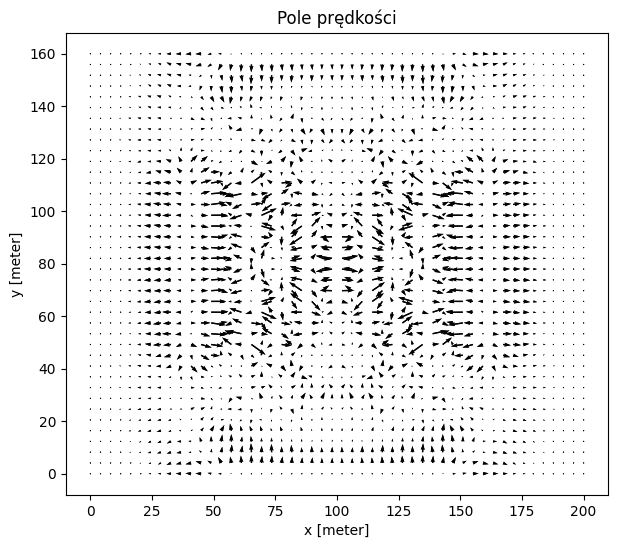

In [70]:
h = output["h"][-1]
uh = output["uh"][-1]
vh = output["vh"][-1]


x = np.linspace(0, Lx.m, h.shape[0]) * si.meter
y = np.linspace(0, Ly.m, h.shape[1]) * si.meter
X, Y = np.meshgrid(x, y, indexing='ij')

u = np.where(h > 1e-8, uh / h, 0)*(si.meter/si.second)
v = np.where(h > 1e-8, vh / h, 0)*(si.meter/si.second)

pyplot.figure(figsize=(7,6))
pyplot.quiver(X.m, Y.m, u.m, v.m, scale=5)
pyplot.quiver(X, Y, u, v, scale=5)
pyplot.gca().xaxis.set_units(si.meter)
pyplot.gca().yaxis.set_units(si.meter)

pyplot.title('Pole prędkości')
pyplot.xlabel(f'x [{x.units}]')
pyplot.ylabel(f'y [{y.units}]')
pyplot.gca().xaxis.set_units(si.meter)
pyplot.gca().yaxis.set_units(si.meter)

pyplot.savefig("predkosci.svg", format="svg")
pyplot.show()

#### W kolejnym kroku wykonano wektoreowe pole prędkości, co widać powyżej. W obszarze początku anomali widać, że fala się odbijała - wektory prędkości ustawione są w przeciwne strony. Jak się spodziewano w obszarze na środku wzdłuż osi y wektory nie są tak chaotyczne.

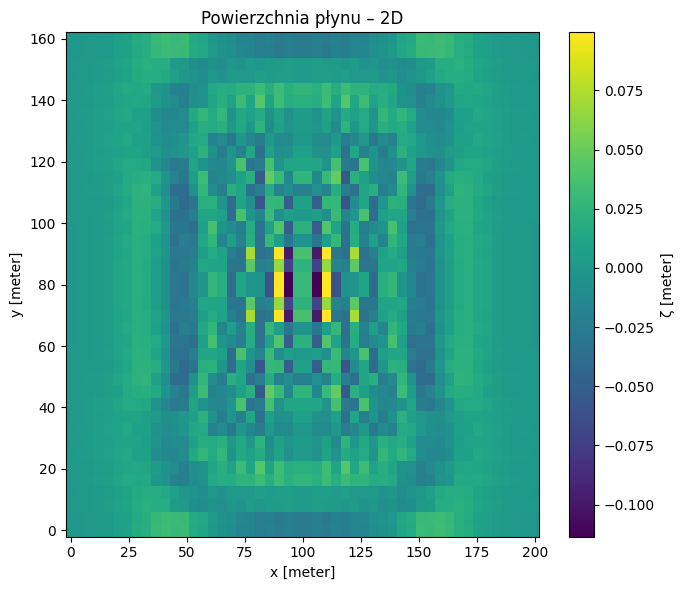

In [71]:
h = output["h"][-1] * si.meter
eta = (h - bathymetry).to(si.meter)

x = np.linspace(0, Lx.m, h.shape[0]) * si.meter
y = np.linspace(0, Ly.m, h.shape[1]) * si.meter
X, Y = np.meshgrid(x, y, indexing="ij")

pyplot.figure(figsize=(7,6))
pc = pyplot.pcolormesh(X.magnitude, Y.magnitude, eta.magnitude, shading="auto")

pyplot.colorbar(pc, label=f'ζ [{zeta.units}]')
pyplot.xlabel(f'x [{x.units}]')
pyplot.ylabel(f'y [{y.units}]')
pyplot.title('Powierzchnia płynu – 2D')
pyplot.tight_layout()
pyplot.savefig("h_2d.svg")
pyplot.show()


#### Powyżej przedstawiono powierzchnię płynu, która jest bardzo podłużna. Przeszkody o dużym promieniu spowodowały duże przewężenie.

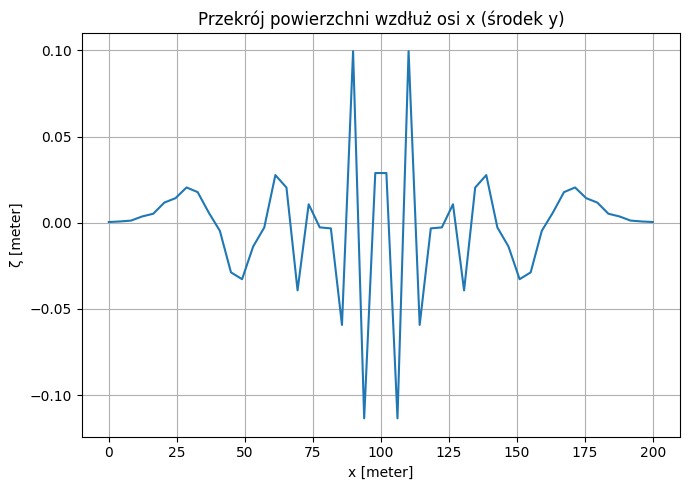

In [72]:
mid_y = h.shape[1] // 2
pyplot.figure(figsize=(7,5))
pyplot.plot(x.magnitude, eta[:, mid_y].magnitude)

pyplot.xlabel(f'x [{x.units}]')
pyplot.ylabel(f'ζ [{zeta.units}]')
pyplot.gca().xaxis.set_units(si.meter)
pyplot.gca().yaxis.set_units(si.meter)
pyplot.title('Przekrój powierzchni wzdłuż osi x (środek y)')
pyplot.grid(True)
pyplot.tight_layout()
pyplot.savefig("h_cross_x.svg")
pyplot.show()


#### Przedstawiono przekrój poprzeczny powierzchni wody (ζ) wzdłuż osi y (w środku domeny x). Krzywa ta jest silnie zaburzona, stąd doskonale uwidacznia ekstrema fali powstałe na skutek interferencji i dyfrakcji na przeszkodach.

#### Maksima (odpowiadające obszarom "żółtym" na mapie konturowej) oraz minima (obszary "granatowe", czyli wklęśnięcia) potwierdzają, że dla wprowadzenia dużych przeszkód dominuje skomplikowany wzór interferencyjny i resztkowy pęd, a nie swobodna propagacja fali.

###  Rozważono takie samo rozmieszczenie wysp, ale ich promień ustalono jako 20m i powtórzono wszytskie powyższe kroki.


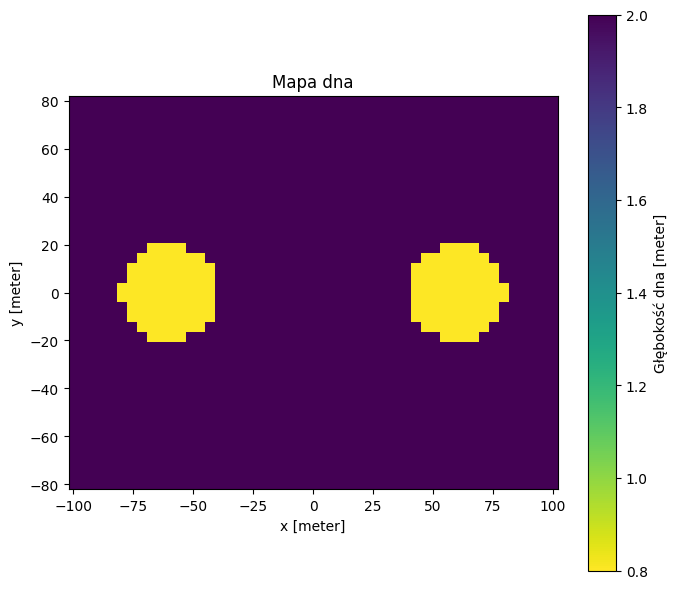

/usr/local/lib/python3.12/dist-packages/matplotlib/collections.py:200: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  offsets = np.asanyarray(offsets, float)
/usr/local/lib/python3.12/dist-packages/numpy/ma/core.py:2383: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  a = np.array(a, copy=None, subok=True)
/usr/local/lib/python3.12/dist-packages/matplotlib/transforms.py:2122: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asanyarray(values)


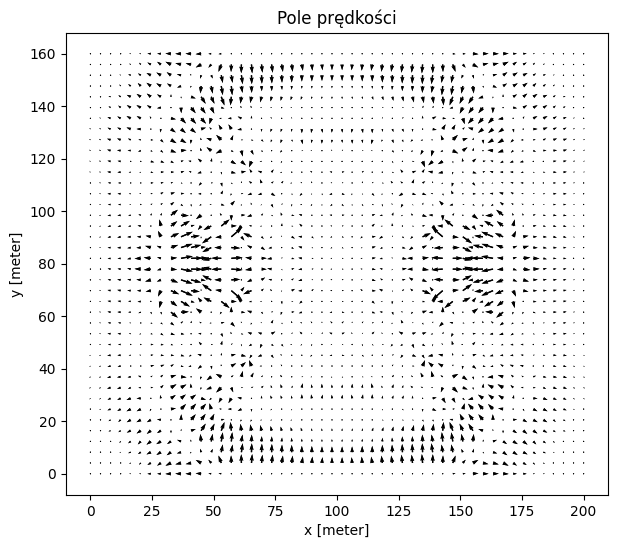

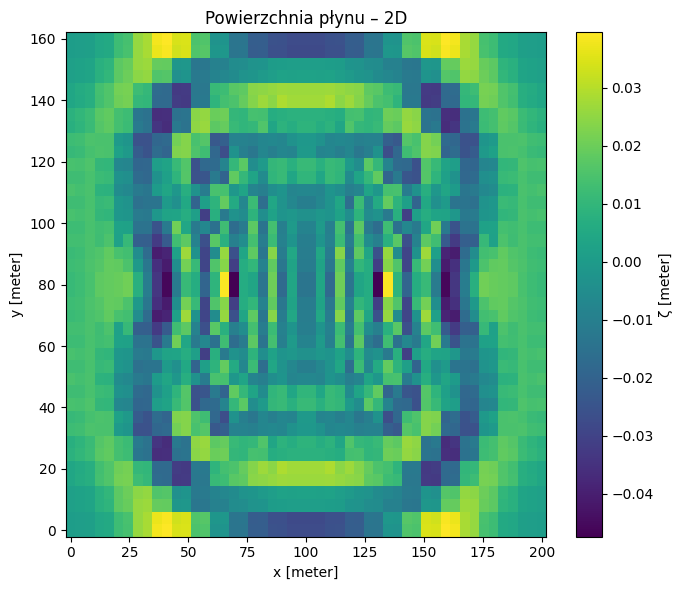

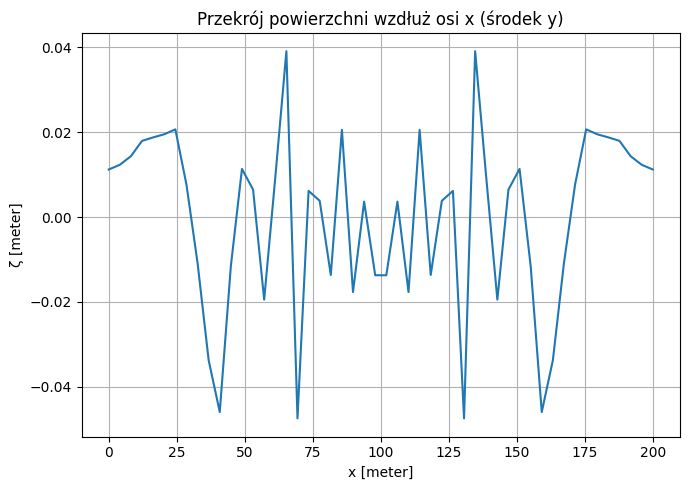

In [73]:
x = np.linspace(-Lx.m/2, Lx.m/2, grid[0])
y = np.linspace(-Ly.m/2, Ly.m/2, grid[1])
X, Y = np.meshgrid(x, y, indexing="ij")
bathymetry = np.full(grid, 2.0)

radius = 20*si.meter
height = .8*si.meter
# pierwsza wyspa
x1 = 60.0
y1 = 0.0
mask1 = (X - x1)**2 + (Y - y1)**2 < radius.m**2
bathymetry[mask1] = height.m
# druga wyspa
x2 = -60.0
y2 = 0.0
mask2 = (X - x2)**2 + (Y - y2)**2 < radius.m**2
bathymetry[mask2] = height.m
bathymetry = bathymetry*si.meter

h_initial = bathymetry + zeta


output = ShallowWaterEquationsIntegrator(
    h_initial=h_initial.m, bathymetry=bathymetry.m,
)(
    nt=90, g=g.m, dt_over_dxy=dt_over_dxy, outfreq=(outfreq:=3)
)

x_with_units = np.linspace(-Lx.m/2, Lx.m/2, X.shape[0]) * si.meter
y_with_units = np.linspace(-Ly.m/2, Ly.m/2, Y.shape[1]) * si.meter
X_values, Y_values = np.meshgrid(x_with_units, y_with_units, indexing="ij")


bathymetry_values = bathymetry.m

bathymetry_units = str(bathymetry.units)
x_units = str(X_values.units)
y_units = str(Y_values.units)

pyplot.figure(figsize=(7, 6))
pc = pyplot.pcolormesh(X_values.m, Y_values.m, bathymetry_values, shading="auto", cmap='viridis_r')

pyplot.colorbar(pc, label=f'Głębokość dna [{bathymetry_units}]')
pyplot.xlabel(f'x [{x_units}]')
pyplot.ylabel(f'y [{y_units}]')
pyplot.title('Mapa dna')
pyplot.gca().set_aspect('equal', adjustable='box')
pyplot.tight_layout()
pyplot.gca().xaxis.set_units(si.meter)
pyplot.gca().yaxis.set_units(si.meter)
pyplot.savefig("Mapa_Dna_2D.svg", format="svg")
pyplot.show()

h = output["h"][-1]
uh = output["uh"][-1]
vh = output["vh"][-1]


x = np.linspace(0, Lx.m, h.shape[0]) * si.meter
y = np.linspace(0, Ly.m, h.shape[1]) * si.meter
X, Y = np.meshgrid(x, y, indexing='ij')

u = np.where(h > 1e-8, uh / h, 0)*(si.meter/si.second)
v = np.where(h > 1e-8, vh / h, 0)*(si.meter/si.second)

pyplot.figure(figsize=(7,6))
pyplot.quiver(X.m, Y.m, u.m, v.m, scale=5)
pyplot.quiver(X, Y, u, v, scale=5)
pyplot.gca().xaxis.set_units(si.meter)
pyplot.gca().yaxis.set_units(si.meter)

pyplot.title('Pole prędkości')
pyplot.xlabel(f'x [{x.units}]')
pyplot.ylabel(f'y [{y.units}]')
pyplot.gca().xaxis.set_units(si.meter)
pyplot.gca().yaxis.set_units(si.meter)

pyplot.savefig("predkosci.svg", format="svg")
pyplot.show()

h = output["h"][-1] * si.meter
eta = (h - bathymetry).to(si.meter)

x = np.linspace(0, Lx.m, h.shape[0]) * si.meter
y = np.linspace(0, Ly.m, h.shape[1]) * si.meter
X, Y = np.meshgrid(x, y, indexing="ij")

pyplot.figure(figsize=(7,6))
pc = pyplot.pcolormesh(X.magnitude, Y.magnitude, eta.magnitude, shading="auto")

pyplot.colorbar(pc, label=f'ζ [{zeta.units}]')
pyplot.xlabel(f'x [{x.units}]')
pyplot.ylabel(f'y [{y.units}]')
pyplot.title('Powierzchnia płynu – 2D')
pyplot.tight_layout()
pyplot.savefig("h_2d.svg")
pyplot.show()


mid_y = h.shape[1] // 2
pyplot.figure(figsize=(7,5))
pyplot.plot(x.magnitude, eta[:, mid_y].magnitude)

pyplot.xlabel(f'x [{x.units}]')
pyplot.ylabel(f'ζ [{zeta.units}]')
pyplot.gca().xaxis.set_units(si.meter)
pyplot.gca().yaxis.set_units(si.meter)
pyplot.title('Przekrój powierzchni wzdłuż osi x (środek y)')
pyplot.grid(True)
pyplot.tight_layout()
pyplot.savefig("h_cross_x.svg")
pyplot.show()



### Jako ostatni przypadek rozważono bardzo małe cylindryczne anomalie, ponieważ promień zmniejszono do 10m.

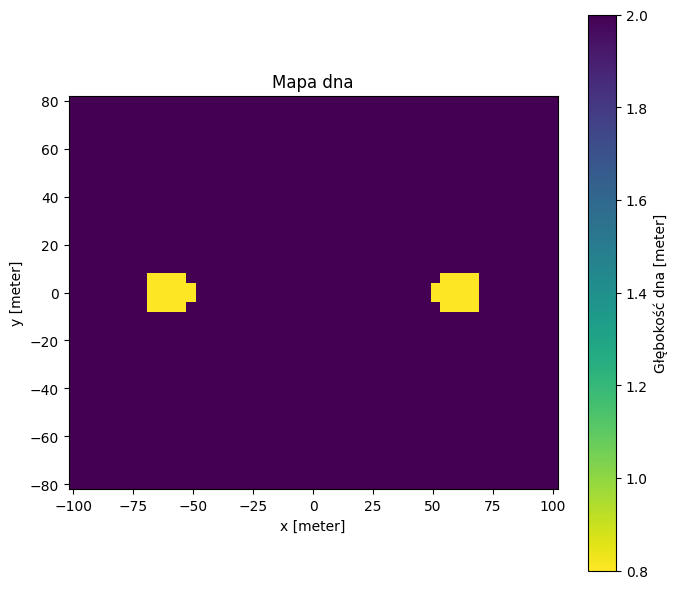

/usr/local/lib/python3.12/dist-packages/matplotlib/collections.py:200: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  offsets = np.asanyarray(offsets, float)
/usr/local/lib/python3.12/dist-packages/numpy/ma/core.py:2383: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  a = np.array(a, copy=None, subok=True)
/usr/local/lib/python3.12/dist-packages/matplotlib/transforms.py:2122: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asanyarray(values)


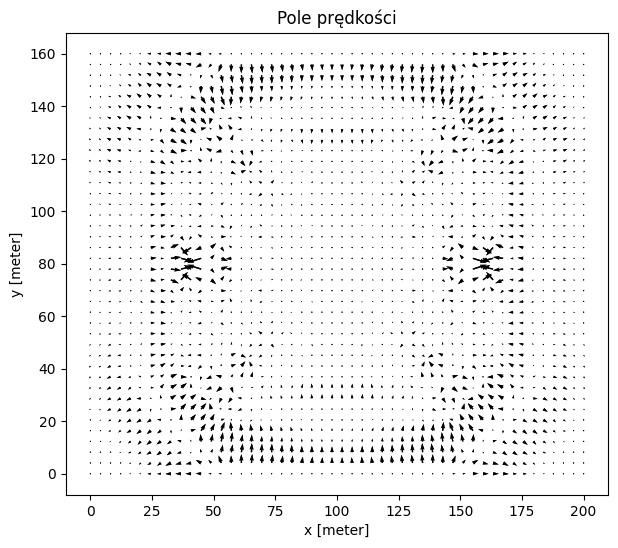

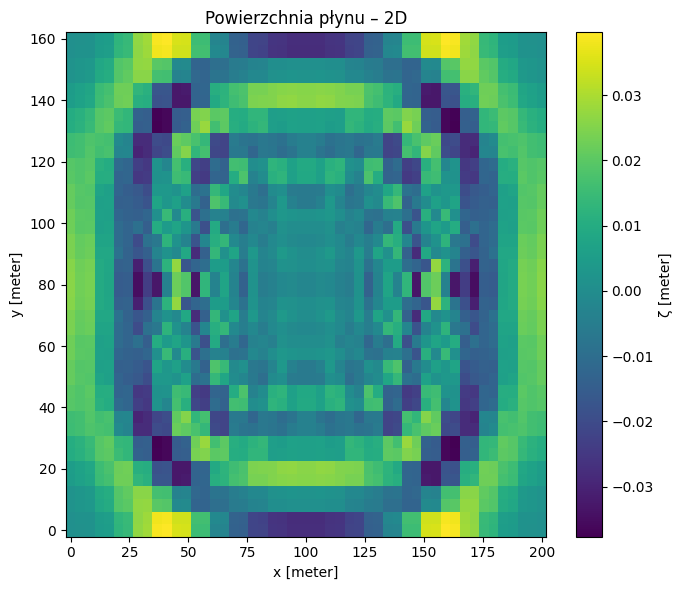

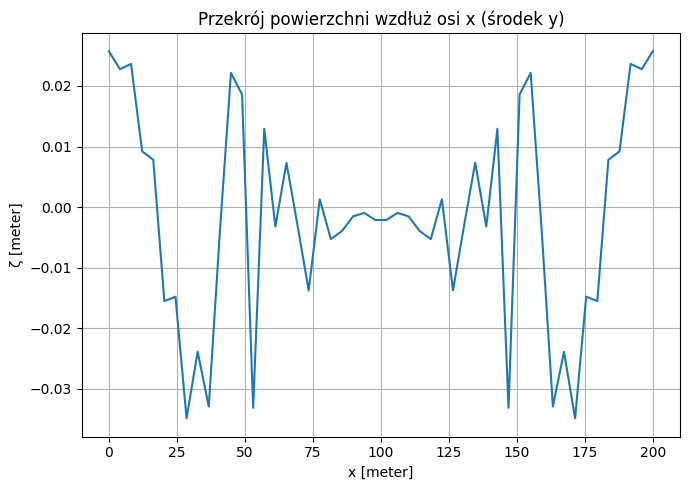

In [74]:
x = np.linspace(-Lx.m/2, Lx.m/2, grid[0])
y = np.linspace(-Ly.m/2, Ly.m/2, grid[1])
X, Y = np.meshgrid(x, y, indexing="ij")
bathymetry = np.full(grid, 2.0)

radius = 10*si.meter
height = .8*si.meter
# pierwsza wyspa
x1 = 60.0
y1 = 0.0
mask1 = (X - x1)**2 + (Y - y1)**2 < radius.m**2
bathymetry[mask1] = height.m
# druga wyspa
x2 = -60.0
y2 = 0.0
mask2 = (X - x2)**2 + (Y - y2)**2 < radius.m**2
bathymetry[mask2] = height.m
bathymetry = bathymetry*si.meter

h_initial = bathymetry + zeta


output = ShallowWaterEquationsIntegrator(
    h_initial=h_initial.m, bathymetry=bathymetry.m,
)(
    nt=90, g=g.m, dt_over_dxy=dt_over_dxy, outfreq=(outfreq:=3)
)

x_with_units = np.linspace(-Lx.m/2, Lx.m/2, X.shape[0]) * si.meter
y_with_units = np.linspace(-Ly.m/2, Ly.m/2, Y.shape[1]) * si.meter
X_values, Y_values = np.meshgrid(x_with_units, y_with_units, indexing="ij")


bathymetry_values = bathymetry.m

bathymetry_units = str(bathymetry.units)
x_units = str(X_values.units)
y_units = str(Y_values.units)

pyplot.figure(figsize=(7, 6))
pc = pyplot.pcolormesh(X_values.m, Y_values.m, bathymetry_values, shading="auto", cmap='viridis_r')

pyplot.colorbar(pc, label=f'Głębokość dna [{bathymetry_units}]')
pyplot.xlabel(f'x [{x_units}]')
pyplot.ylabel(f'y [{y_units}]')
pyplot.title('Mapa dna')
pyplot.gca().set_aspect('equal', adjustable='box')
pyplot.tight_layout()
pyplot.gca().xaxis.set_units(si.meter)
pyplot.gca().yaxis.set_units(si.meter)
pyplot.savefig("Mapa_Dna_2D.svg", format="svg")
pyplot.show()

h = output["h"][-1]
uh = output["uh"][-1]
vh = output["vh"][-1]


x = np.linspace(0, Lx.m, h.shape[0]) * si.meter
y = np.linspace(0, Ly.m, h.shape[1]) * si.meter
X, Y = np.meshgrid(x, y, indexing='ij')

u = np.where(h > 1e-8, uh / h, 0)*(si.meter/si.second)
v = np.where(h > 1e-8, vh / h, 0)*(si.meter/si.second)

pyplot.figure(figsize=(7,6))
pyplot.quiver(X.m, Y.m, u.m, v.m, scale=5)
pyplot.quiver(X, Y, u, v, scale=5)
pyplot.gca().xaxis.set_units(si.meter)
pyplot.gca().yaxis.set_units(si.meter)

pyplot.title('Pole prędkości')
pyplot.xlabel(f'x [{x.units}]')
pyplot.ylabel(f'y [{y.units}]')
pyplot.gca().xaxis.set_units(si.meter)
pyplot.gca().yaxis.set_units(si.meter)

pyplot.savefig("predkosci.svg", format="svg")
pyplot.show()

h = output["h"][-1] * si.meter
eta = (h - bathymetry).to(si.meter)

x = np.linspace(0, Lx.m, h.shape[0]) * si.meter
y = np.linspace(0, Ly.m, h.shape[1]) * si.meter
X, Y = np.meshgrid(x, y, indexing="ij")

pyplot.figure(figsize=(7,6))
pc = pyplot.pcolormesh(X.magnitude, Y.magnitude, eta.magnitude, shading="auto")

pyplot.colorbar(pc, label=f'ζ [{zeta.units}]')
pyplot.xlabel(f'x [{x.units}]')
pyplot.ylabel(f'y [{y.units}]')
pyplot.title('Powierzchnia płynu – 2D')
pyplot.tight_layout()
pyplot.savefig("h_2d.svg")
pyplot.show()


mid_y = h.shape[1] // 2
pyplot.figure(figsize=(7,5))
pyplot.plot(x.magnitude, eta[:, mid_y].magnitude)

pyplot.xlabel(f'x [{x.units}]')
pyplot.ylabel(f'ζ [{zeta.units}]')
pyplot.gca().xaxis.set_units(si.meter)
pyplot.gca().yaxis.set_units(si.meter)
pyplot.title('Przekrój powierzchni wzdłuż osi x (środek y)')
pyplot.grid(True)
pyplot.tight_layout()
pyplot.savefig("h_cross_x.svg")
pyplot.show()



## Dla najmniejszego promienia sprawdzono jak wyniki zmienią się po dwukrotnym zwiększeniu rozdzielczości przestrzennej i czasowej, co wykonano poniżej.
## - rozmiar siatki: grid = (100,80)
## - rozdzielczość przestrzenna $\Delta x$ = $L_x$/100=20m; $\Delta y$ = $L_y$/80=20m
## - rozdzielczość czasowa $\Delta t$ = 0.125s
## - liczba kroków czasowych: nt=150

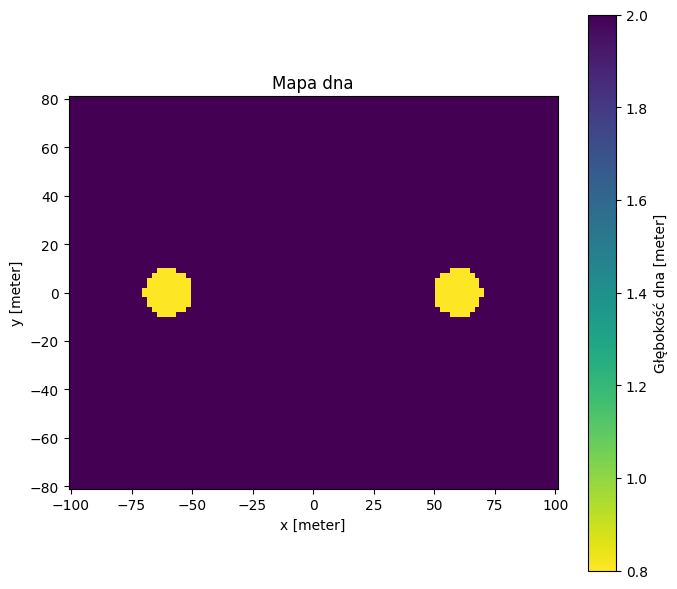

/usr/local/lib/python3.12/dist-packages/matplotlib/collections.py:200: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  offsets = np.asanyarray(offsets, float)
/usr/local/lib/python3.12/dist-packages/numpy/ma/core.py:2383: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  a = np.array(a, copy=None, subok=True)
/usr/local/lib/python3.12/dist-packages/matplotlib/transforms.py:2122: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asanyarray(values)


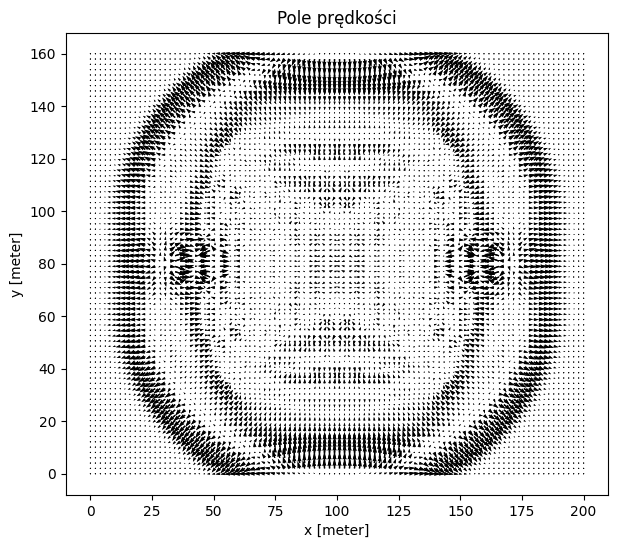

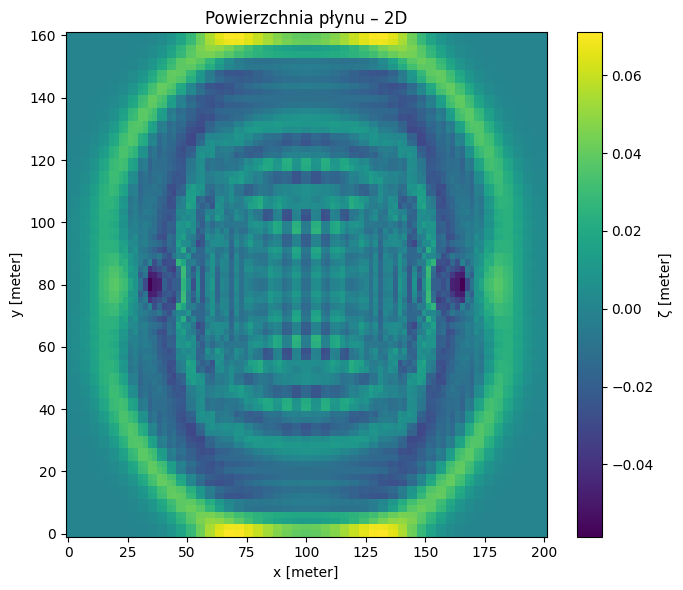

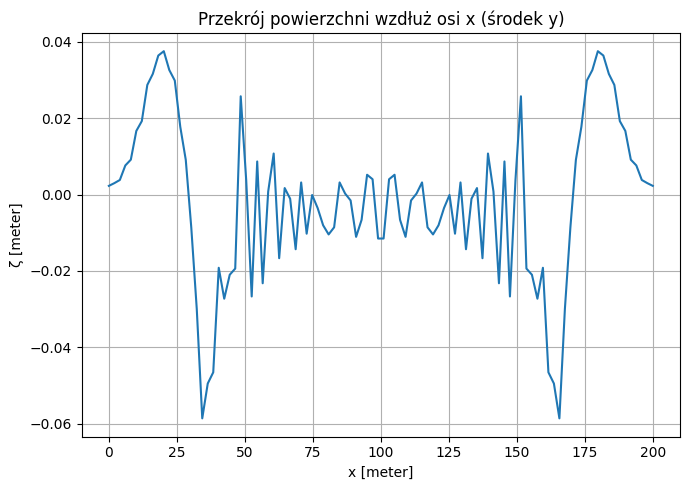

In [75]:
grid = (100, 80)
dx = Lx / grid[0]
dy = Ly / grid[1]
dt = .125*si.second
dt_over_dxy = ((dt/dx).m, (dt/dy).m)

x = np.linspace(-Lx.m/2, Lx.m/2, grid[0])
y = np.linspace(-Ly.m/2, Ly.m/2, grid[1])
X, Y = np.meshgrid(x, y, indexing="ij")

zeta = np.zeros(grid, dtype=float)
zeta[
    grid[0] // 2 - grid[0] // 20:
    grid[0] // 2 + grid[0] // 20,
    grid[1] // 2 - grid[1] // 20:
    grid[1] // 2 + grid[1] // 20
] += .25
zeta=zeta*si.meter

x = np.linspace(-Lx.m/2, Lx.m/2, grid[0])
y = np.linspace(-Ly.m/2, Ly.m/2, grid[1])
X, Y = np.meshgrid(x, y, indexing="ij")
bathymetry = np.full(grid, 2.0)

radius = 10*si.meter
height = .8*si.meter
# pierwsza wyspa
x1 = 60.0
y1 = 0.0
mask1 = (X - x1)**2 + (Y - y1)**2 < radius.m**2
bathymetry[mask1] = height.m
# druga wyspa
x2 = -60.0
y2 = 0.0
mask2 = (X - x2)**2 + (Y - y2)**2 < radius.m**2
bathymetry[mask2] = height.m
bathymetry = bathymetry*si.meter

h_initial = bathymetry + zeta


output = ShallowWaterEquationsIntegrator(
    h_initial=h_initial.m, bathymetry=bathymetry.m,
)(
    nt=150, g=g.m, dt_over_dxy=dt_over_dxy, outfreq=(outfreq:=3)
)

x_with_units = np.linspace(-Lx.m/2, Lx.m/2, X.shape[0]) * si.meter
y_with_units = np.linspace(-Ly.m/2, Ly.m/2, Y.shape[1]) * si.meter
X_values, Y_values = np.meshgrid(x_with_units, y_with_units, indexing="ij")


bathymetry_values = bathymetry.m

bathymetry_units = str(bathymetry.units)
x_units = str(X_values.units)
y_units = str(Y_values.units)

pyplot.figure(figsize=(7, 6))
pc = pyplot.pcolormesh(X_values.m, Y_values.m, bathymetry_values, shading="auto", cmap='viridis_r')

pyplot.colorbar(pc, label=f'Głębokość dna [{bathymetry_units}]')
pyplot.xlabel(f'x [{x_units}]')
pyplot.ylabel(f'y [{y_units}]')
pyplot.title('Mapa dna')
pyplot.gca().set_aspect('equal', adjustable='box')
pyplot.tight_layout()
pyplot.gca().xaxis.set_units(si.meter)
pyplot.gca().yaxis.set_units(si.meter)
pyplot.savefig("Mapa_Dna_2D.svg", format="svg")
pyplot.show()

h = output["h"][-1]
uh = output["uh"][-1]
vh = output["vh"][-1]


x = np.linspace(0, Lx.m, h.shape[0]) * si.meter
y = np.linspace(0, Ly.m, h.shape[1]) * si.meter
X, Y = np.meshgrid(x, y, indexing='ij')

u = np.where(h > 1e-8, uh / h, 0)*(si.meter/si.second)
v = np.where(h > 1e-8, vh / h, 0)*(si.meter/si.second)

pyplot.figure(figsize=(7,6))
pyplot.quiver(X.m, Y.m, u.m, v.m, scale=5)
pyplot.quiver(X, Y, u, v, scale=5)
pyplot.gca().xaxis.set_units(si.meter)
pyplot.gca().yaxis.set_units(si.meter)

pyplot.title('Pole prędkości')
pyplot.xlabel(f'x [{x.units}]')
pyplot.ylabel(f'y [{y.units}]')
pyplot.gca().xaxis.set_units(si.meter)
pyplot.gca().yaxis.set_units(si.meter)

pyplot.savefig("predkosci.svg", format="svg")
pyplot.show()

h = output["h"][-1] * si.meter
eta = (h - bathymetry).to(si.meter)

x = np.linspace(0, Lx.m, h.shape[0]) * si.meter
y = np.linspace(0, Ly.m, h.shape[1]) * si.meter
X, Y = np.meshgrid(x, y, indexing="ij")

pyplot.figure(figsize=(7,6))
pc = pyplot.pcolormesh(X.magnitude, Y.magnitude, eta.magnitude, shading="auto")

pyplot.colorbar(pc, label=f'ζ [{zeta.units}]')
pyplot.xlabel(f'x [{x.units}]')
pyplot.ylabel(f'y [{y.units}]')
pyplot.title('Powierzchnia płynu – 2D')
pyplot.tight_layout()
pyplot.savefig("h_2d.svg")
pyplot.show()


mid_y = h.shape[1] // 2
pyplot.figure(figsize=(7,5))
pyplot.plot(x.magnitude, eta[:, mid_y].magnitude)

pyplot.xlabel(f'x [{x.units}]')
pyplot.ylabel(f'ζ [{zeta.units}]')
pyplot.gca().xaxis.set_units(si.meter)
pyplot.gca().yaxis.set_units(si.meter)
pyplot.title('Przekrój powierzchni wzdłuż osi x (środek y)')
pyplot.grid(True)
pyplot.tight_layout()
pyplot.savefig("h_cross_x.svg")
pyplot.show()



# WNIOSKI
##  Wpływ rozmiaru przeszkody
#### Dla największej wartości promienia amplituda fal okazała się być największa. Duża przeszkoda - duża fala. Dla najmniejszych przeszkód (r=10m) pole wektorowe prędkości przypomina już swobodne rozprzestrzenianie się fal z tym wyjątkiem, że widać małe zaburzenia przy przeszkodach, ale mają one już tylko wpływ lokalny.
#### Powierzchnia płynu w widoku od góry dla największego promienia była bardzo podłużna, jej pionowe boki były do siebie praktycznie równoległe, stąd wywnioskowano, że duże przeszkody działają jak silne przewężenia. Dla przypadku pośredniego widok ten przypominał już bardziej ściśnięty na środku pierścień, można dostrzec, że na górze i dole występują zaokrąglenia. Najmniejszy promień przeszkód spowodował, że powierzchnia płynu stała się prawie elipsą. Jest ona bardziej gładka, ale wciąż widać wpływ anomali. Małe przeszkody pozwalają fali na swobodne rozprzestrzenianie się w kształcie zbliżonym do pierścienia/elipsy.
##  Wpływ rozdzielczości numerycznej
#### Wyniki są zbieżne  zwiększenie rozdzielczości nie zmieniło znacząco fizyki, ale poprawiło szczegółowość Mniejsze pixele sprawiają, że powierzchnia płynu widziana z lotu ptaka jest znacznie łatwiejsza do odczytania, tzn. dużo lepiej widać gdzie zlokalizowane są wyspy. Podobnie pole wektorowe jest czytelniejsze, a sama symulacja bardziej płynna i przyjemniejsza do oglądania.